# KLASIFIKASI PENYAKIT JANTUNG MENGGUNAKAN OLS

### 1. DATASET

#### 1.1 Load Dataset

Dataset dibaca menggunakan numpy.genfromtxt karena seluruh data bersifat numerik. Baris header dilewati agar tidak mengganggu proses komputasi.

In [ ]:
import numpy as np                  # Library numerik untuk komputasi array
import matplotlib.pyplot as plt     # Library visualisasi grafik
import pandas as pd                 # Library untuk manipulasi data

data = pd.read_csv("heart.csv")
# df.to_numpy()

print("Shape awal dataset:", data.shape)


Shape awal dataset: (1025, 14)


#### 1.2 Cek Missing Value

Missing value dicek untuk memastikan tidak ada nilai kosong yang dapat menyebabkan error pada perhitungan matriks OLS.

In [ ]:
# Menghitung jumlah nilai kosong (NaN)
missing = np.isnan(data).sum()
print("Jumlah missing value:", missing)


Jumlah missing value: age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64


#### 1.3 Menghapus Duplikasi Data

Duplikasi data dapat menyebabkan bias model. Oleh karena itu, baris duplikat dihapus menggunakan np.unique.

In [ ]:
# Jumlah data sebelum penghapusan duplikat
before = data.shape[0]

# Menghapus baris duplikat
data = np.unique(data, axis=0)

# Jumlah data setelah penghapusan duplikat
after = data.shape[0]

print("Sebelum duplikat:", before)
print("Sesudah duplikat :", after)


Sebelum duplikat: 1025
Sesudah duplikat : 302


#### 1.4 Pemisahan Fitur dan Target

Kolom terakhir dataset merupakan variabel target, sedangkan kolom lainnya adalah fitur prediktor.

In [ ]:
# Semua kolom kecuali terakhir sebagai fitur
X = data[:, :-1]

# Kolom terakhir sebagai label (0 = tidak sakit, 1 = sakit)
y = data[:, -1]

print("Shape X:", X.shape)
print("Shape y:", y.shape)


Shape X: (302, 13)
Shape y: (302,)


#### 1.5 Outlier Removal (Z-Score)

Outlier dapat memengaruhi estimasi parameter OLS. Metode Z-score digunakan untuk menghapus data ekstrem.

In [ ]:
def remove_outliers_zscore(X, y, threshold=3):
    mean = X.mean(axis=0)           # Rata-rata tiap fitur
    std  = X.std(axis=0)            # Standar deviasi tiap fitur

    z = np.abs((X - mean) / std)    # Hitung nilai Z-score
    mask = (z < threshold).all(axis=1)  # Ambil data tanpa outlier

    return X[mask], y[mask]

# Terapkan penghapusan outlier
X, y = remove_outliers_zscore(X, y)

print("Shape setelah outlier removal:", X.shape)


Shape setelah outlier removal: (287, 13)


#### 1.6 Split Data Train & Test

In [ ]:
np.random.seed(42)                 # Seed agar hasil konsisten

indices = np.random.permutation(len(X))  # Acak indeks data
split = int(0.8 * len(X))          # 80% data latih

train_idx = indices[:split]
test_idx  = indices[split:]

X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y[train_idx], y[test_idx]


#### 1.7 Normalisasi Min-Max

Normalisasi diperlukan agar semua fitur berada pada skala yang sama sehingga model stabil.

In [ ]:
X_min = X_train.min(axis=0)        # Minimum fitur data latih
X_max = X_train.max(axis=0)        # Maksimum fitur data latih

X_train = (X_train - X_min) / (X_max - X_min)
X_test  = (X_test  - X_min) / (X_max - X_min)


# 2. Eploratory Data Analysisi (EDA)

Boxplot digunakan untuk melihat sebaran data dan mendeteksi outlier secara visual.

In [ ]:

# numerical_cols = data.drop(columns=[target_col]).columns

# for col in numerical_cols:
#     plt.figure()
#     sns.boxplot(x=data[target_col], y=df[col])
#     plt.title(f"Boxplot {col} terhadap Target")
#     plt.xlabel("Target")
#     plt.ylabel(col)
#     plt.show()

Bar chart menunjukkan apakah dataset seimbang atau tidak antar kelas.

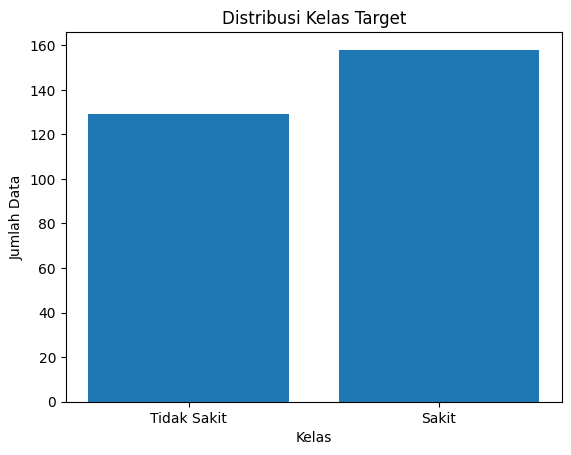

In [ ]:
labels, counts = np.unique(y, return_counts=True)

plt.figure()
plt.bar(labels, counts)
plt.title("Distribusi Kelas Target")
plt.xlabel("Kelas")
plt.ylabel("Jumlah Data")
plt.xticks([0, 1], ["Tidak Sakit", "Sakit"])
plt.show()


Pie chart memperjelas proporsi data antar kelas dalam bentuk persentase.

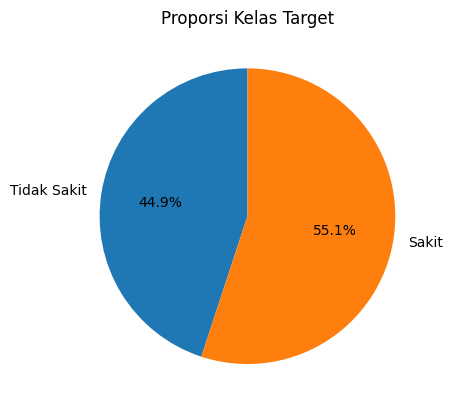

In [ ]:
plt.figure()
plt.pie(
    counts,
    labels=["Tidak Sakit", "Sakit"],
    autopct="%1.1f%%",
    startangle=90
)
plt.title("Proporsi Kelas Target")
plt.show()


# Modelling

Model regresi y = w0+w1.x1+w2.x2+...+w13.x13

In [ ]:
from ols import OLSClassifier


ln = OLSClassifier()
ln.fit(X_train, y_train)
print("Bobot model (coef_):")
print(ln.coef_)

Bobot model (coef_):
[ 0.7490294   0.0318969  -0.17392415  0.26713294 -0.13265013 -0.15015581
  0.04316855  0.06805711  0.33175472 -0.13850851 -0.2487675   0.19760822
 -0.41468644 -0.32513562]


#### 3.4 Confusion Matrix

Confusion matrix digunakan untuk mengevaluasi performa model klasifikasi dengan menghitung jumlah prediksi benar dan salah pada masing-masing kelas. Matriks ini menjadi dasar perhitungan accuracy, precision, recall, dan F1-score.

In [ ]:
def confusion_matrix(y_true, y_pred):
    # True Negative: data aktual 0 dan diprediksi 0
    tn = np.sum((y_true == 0) & (y_pred == 0))
    
    # False Positive: data aktual 0 tapi diprediksi 1
    fp = np.sum((y_true == 0) & (y_pred == 1))
    
    # False Negative: data aktual 1 tapi diprediksi 0
    fn = np.sum((y_true == 1) & (y_pred == 0))
    
    # True Positive: data aktual 1 dan diprediksi 1
    tp = np.sum((y_true == 1) & (y_pred == 1))

    # Mengembalikan confusion matrix
    return np.array([[tp, fp],
                     [fn, tn]])


##### Model Default

Model pertama dilatih menggunakan parameter default untuk dijadikan baseline. Hasil training dan testing dibandingkan untuk melihat apakah model mengalami overfitting.

In [ ]:
ln = OLSClassifier()        # Inisialisasi model dengan parameter default
ln.fit(X_train, y_train)   # Training model

# Prediksi data testing
y_pred = ln.predict(X_test)
cm_test = confusion_matrix(y_test, y_pred)

print("data test DEFAULT")
print(cm_test)

# Prediksi data training
y_pred_train = ln.predict(X_train)
cm_train = confusion_matrix(y_train, y_pred_train)

print("data train DEFAULT")
print(cm_train)


data test DEFAULT
[[36  7]
 [ 2 13]]
data train DEFAULT
[[111  20]
 [  9  89]]


Akurasi training lebih tinggi dibanding testing → indikasi overfitting ringan, wajar untuk model linear sederhana.

##### Tuning Learning Rate

Learning rate menentukan seberapa besar langkah pembaruan bobot saat training menggunakan gradient descent. Nilai terlalu besar bisa tidak stabil, terlalu kecil membuat model sulit konvergen.

In [ ]:
lr = [0.1, 0.01, 0.001, 0.0001]
for learning_rate in lr:
    print("Learning Rate:", learning_rate)
    ln = OLSClassifier(lr=learning_rate, solver='gradient_descent')
    ln.fit(X_train, y_train)
    y_pred = ln.predict(X_test)
    print("Accuracy - TEST")
    print(np.mean(y_pred == y_test))

Learning Rate: 0.1
Accuracy - TEST
0.8620689655172413
Learning Rate: 0.01
Accuracy - TEST
0.8620689655172413
Learning Rate: 0.001
Accuracy - TEST
0.7413793103448276
Learning Rate: 0.0001
Accuracy - TEST
0.3448275862068966


lr = 0.1 dan 0.01 → hasil terbaik
lr terlalu kecil → model gagal belajar (akurasi jatuh drastis)

##### Tuning Max Iteration

Max iteration menentukan jumlah maksimum proses pembelajaran. Terlalu sedikit menyebabkan model belum konvergen, terlalu banyak bisa menyebabkan overfitting.

In [ ]:
max_iter = [100, 500, 1000, 5000]
for maxiter in max_iter:
    print("Max Iterations:", maxiter)
    ln = OLSClassifier(lr=0.01, max_iter=maxiter, solver='gradient_descent')
    ln.fit(X_train, y_train)
    y_pred = ln.predict(X_test)
    print("Accuracy - TEST")
    print(np.mean(y_pred == y_test))

Max Iterations: 100
Accuracy - TEST
0.7413793103448276
Max Iterations: 500
Accuracy - TEST
0.8275862068965517
Max Iterations: 1000
Accuracy - TEST
0.8620689655172413
Max Iterations: 5000
Accuracy - TEST
0.8620689655172413


Iterasi ≥ 1000 memberikan hasil stabil
Penambahan iterasi berlebih tidak meningkatkan performa signifikan

##### Pengaruh Intercept

Intercept berfungsi sebagai bias model. Tanpa intercept, model dipaksa melewati titik nol yang seringkali tidak realistis.

In [ ]:
print("False")
ln = OLSClassifier(lr=0.01, max_iter=1000, solver='gradient_descent', fit_intercept=False)
ln.fit(X_train, y_train)
y_pred = ln.predict(X_test)
print("Accuracy - TEST")
print(np.mean(y_pred == y_test))

print("True")
ln = OLSClassifier(lr=0.01, max_iter=1000, solver='gradient_descent', fit_intercept=True)
ln.fit(X_train, y_train)
y_pred = ln.predict(X_test)
print("Accuracy - TEST")
print(np.mean(y_pred == y_test))

False
Accuracy - TEST
0.8448275862068966
True
Accuracy - TEST
0.8620689655172413


Model dengan intercept memberikan hasil lebih baik dan lebih stabil.

##### Regularisasi (Alpha)

Regularisasi digunakan untuk mengontrol kompleksitas model dan mengurangi overfitting.

In [ ]:
alpha = [0.0, 0.1, 0.5, 1.0]
for maxiter in alpha:
    print("Max Iterations:", maxiter)
    ln = OLSClassifier(lr=0.01, max_iter=1000, solver='gradient_descent', alpha=maxiter)
    ln.fit(X_train, y_train)
    y_pred = ln.predict(X_test)
    print("Accuracy - TEST")
    print(np.mean(y_pred == y_test))

Max Iterations: 0.0
Accuracy - TEST
0.8620689655172413
Max Iterations: 0.1
Accuracy - TEST
0.8620689655172413
Max Iterations: 0.5
Accuracy - TEST
0.8275862068965517
Max Iterations: 1.0
Accuracy - TEST
0.8103448275862069


Regularisasi ringan masih aman, tetapi alpha besar menurunkan akurasi karena model terlalu dibatasi.

##### Model Terbaik vs Default

Model hasil tuning dibandingkan dengan model default untuk melihat peningkatan performa dan generalisasi.

In [ ]:
ln = OLSClassifier(lr=0.01, max_iter=1000, solver='gradient_descent', fit_intercept=True)
ln.fit(X_train, y_train)
y_pred = ln.predict(X_test)
print("data test parameter tuning")
print(confusion_matrix(y_test, y_pred))
print(np.mean(y_test == y_pred))

y_pred_train = ln.predict(X_train)
print("data train parameter tuning")
print(confusion_matrix(y_train, y_pred_train))
print(np.mean(y_pred_train == y_train))

ln = OLSClassifier()
ln.fit(X_train, y_train)
y_pred = ln.predict(X_test)
print("data test DEFAULT")
print(confusion_matrix(y_test, y_pred))
print(np.mean(y_pred == y_test))


y_pred_train = ln.predict(X_train)
print("data train DEFAULT")
print(confusion_matrix(y_train, y_pred_train))
print(np.mean(y_pred_train == y_train))  

data test parameter tuning
[[36  6]
 [ 2 14]]
0.8620689655172413
data train parameter tuning
[[103  25]
 [ 17  84]]
0.8165938864628821
data test DEFAULT
[[36  7]
 [ 2 13]]
0.8448275862068966
data train DEFAULT
[[111  20]
 [  9  89]]
0.8733624454148472


Model tuning lebih seimbang
Model default cenderung overfitting

##### Prediksi Data Baru

Model digunakan untuk memprediksi satu data pasien baru yang telah dinormalisasi.

In [ ]:
x_baru = [70,1,2,160,269,0,1,112,1,2.9,1,1,3]

X_barunorm = (np.array(x_baru) - X_min) / (X_max - X_min)
print(ln.predict([X_barunorm]))
print(ln.predict_proba([X_barunorm]))
print(ln.predict_percentage([X_barunorm]))

[0]
[[0.96873745 0.03126255]]
96.87


In [ ]:
ln.predict([[70,1,2,160,269,0,1,112,1,2.9,1,1,3]])

array([0])

In [ ]:
ln.predict_proba([[70,1,2,160,269,0,1,112,1,2.9,1,1,3]])

array([[1., 0.]])

##### Evaluasi Akhir Model

Evaluasi akhir dilakukan menggunakan accuracy, precision, recall, dan F1-score untuk menilai performa model secara menyeluruh.

In [ ]:
def classification_report(cm):
    TN, FP = cm[0]
    FN, TP = cm[1]

    accuracy  = (TP + TN) / cm.sum()
    precision = TP / (TP + FP) if (TP + FP) else 0
    recall    = TP / (TP + FN) if (TP + FN) else 0
    f1        = 2 * precision * recall / (precision + recall) if (precision + recall) else 0

    return accuracy, precision, recall, f1


In [ ]:
# Hitung metrik TRAIN
acc_tr, prec_tr, rec_tr, f1_tr = classification_report(cm_train)

# Hitung metrik TEST
acc_te, prec_te, rec_te, f1_te = classification_report(cm_test)

print("\n=== METRIK TRAIN ===")
print("Accuracy :", acc_tr)
print("Precision:", prec_tr)
print("Recall   :", rec_tr)
print("F1-score :", f1_tr)

print("\n=== METRIK TEST ===")
print("Accuracy :", acc_te)
print("Precision:", prec_te)
print("Recall   :", rec_te)
print("F1-score :", f1_te)



=== METRIK TRAIN ===
Accuracy : 0.8733624454148472
Precision: 0.8165137614678899
Recall   : 0.9081632653061225
F1-score : 0.8599033816425121

=== METRIK TEST ===
Accuracy : 0.8448275862068966
Precision: 0.65
Recall   : 0.8666666666666667
F1-score : 0.7428571428571429


In [ ]:
import tkinter as tk
from tkinter import ttk
import numpy as np
import pandas as pd

df = pd.read_csv("heart.csv").drop(columns=["target"])
def normalize(x):
    return(x - x.min(axis=0)) / (x.max(axis=0) - x.min(axis=0))


def predict_btn():
    input_age_values = float(input_age.get())

    if dropdown_sex.get() == "Laki-Laki":
        dropdown_sex_value = 1
    elif dropdown_sex.get() == "Perempuan":
        dropdown_sex_value = 0

    input_cp_value = int(input_cp.get())
    input_trestbps_value = int(input_trestbps.get())
    input_chol_value = int(input_chol.get())
    
    if dropdown_fbs.get() == "yes":
        dropdown_fbs_value = 1
    elif dropdown_fbs.get() == "no":
        dropdown_fbs_value = 0

    input_restecg_value = int(input_restecg.get())
    input_thalach_value = int(input_thalach.get())
    input_exang_value = int(input_exang.get())
    input_oldpeak_value = float(input_oldpeak.get())
    input_slope_value = int(input_slope.get())
    input_ca_value = int(input_ca.get())
    input_thal_value = int(input_thal.get())

    array_input = [input_age_values, dropdown_sex_value, input_cp_value, input_trestbps_value, input_chol_value, dropdown_fbs_value, input_restecg_value, input_thalach_value, input_exang_value, input_oldpeak_value, input_slope_value, input_ca_value, input_thal_value]
    array_input_norm = (np.array(array_input) - X_min) / (X_max - X_min)
    array_input_norm = array_input_norm.reshape(1, -1)


    pred = ln.predict(array_input_norm)[0]
    if pred == 1:
        pred = "Dideteksi Sakit Jantung 💔"
    else:
        pred = "Anda Dideteksi Sehat 💖"
    result_predict.config(text=f"Prediksi: {pred}")

    # print(array_input_norm)


root = tk.Tk()
root.title("aplikasi regresi tapi clasifikasi 😭")
root.geometry("400x500")
root.resizable(True, True)
# root.minsize(350, 350)
# root.maxsize(600, 600)

# Buat grid fleksibel
# root.columnconfigure(0, weight=1)

title = ttk.Label(root, text="Heart Scanner 💖", font=("Poppins", 15))
title.grid(column=0, row=0, columnspan=3, sticky="n", pady=10)

text_input_age = tk.Label(root, text="Input Age")
text_input_age.grid(column=0, row=1, padx=5)
input_age = ttk.Entry()
input_age.grid(column=1, row=1, padx=5, pady=5)

text_input_sex = tk.Label(root, text="Input Sex")
text_input_sex.grid(column=0, row=2, padx=5)
dropdown_sex = ttk.Combobox(
    root,
    values=["Laki-Laki", "Perempuan"],
    state="readonly",
    width=17
)

dropdown_sex.set("Laki-Laki")
dropdown_sex.grid(column=1, row=2, pady=5)

text_input_cp = tk.Label(root, text="Input cp")
text_input_cp.grid(column=0, row=3, padx=5)
input_cp = ttk.Entry()
input_cp.grid(column=1, row=3, padx=5, pady=5)

text_input_trestbps = tk.Label(root, text="Input trestbps")
text_input_trestbps.grid(column=0, row=4, padx=5)
input_trestbps = ttk.Entry()
input_trestbps.grid(column=1, row=4, padx=5, pady=5)

text_input_chol = tk.Label(root, text="Input chol")
text_input_chol.grid(column=0, row=5, padx=5)
input_chol = ttk.Entry()
input_chol.grid(column=1, row=5, padx=5, pady=5)

text_input_fbs = tk.Label(root, text="Input Fbs")
text_input_fbs.grid(column=0, row=6, padx=5)
dropdown_fbs = ttk.Combobox(
    root,
    values=["yes", "no"],
    state="readonly",
    width=17
)

dropdown_fbs.set("yes")
dropdown_fbs.grid(column=1, row=6, pady=5)

text_input_restecg = tk.Label(root, text="Input restecg")
text_input_restecg.grid(column=0, row=7, padx=5)
input_restecg = ttk.Entry()
input_restecg.grid(column=1, row=7, padx=5, pady=5)

text_input_thalach = tk.Label(root, text="Input thalach")
text_input_thalach.grid(column=0, row=8, padx=5)
input_thalach = ttk.Entry()
input_thalach.grid(column=1, row=8, padx=5, pady=5)

text_input_exang = tk.Label(root, text="Input exang")
text_input_exang.grid(column=0, row=9, padx=5)
input_exang = ttk.Entry()
input_exang.grid(column=1, row=9, padx=5, pady=5)

text_input_oldpeak = tk.Label(root, text="Input oldpeak")
text_input_oldpeak.grid(column=0, row=10, padx=5)
input_oldpeak = ttk.Entry()
input_oldpeak.grid(column=1, row=10, padx=5, pady=5)

text_input_slope = tk.Label(root, text="Input slope")
text_input_slope.grid(column=0, row=11, padx=5)
input_slope = ttk.Entry()
input_slope.grid(column=1, row=11, padx=5, pady=5)

text_input_ca = tk.Label(root, text="Input ca")
text_input_ca.grid(column=0, row=12, padx=5)
input_ca = ttk.Entry()
input_ca.grid(column=1, row=12, padx=5, pady=5)

text_input_thal = tk.Label(root, text="Input thal")
text_input_thal.grid(column=0, row=13, padx=5)
input_thal = ttk.Entry()
input_thal.grid(column=1, row=13, padx=5, pady=5)


btn_predict = ttk.Button(root, text="Predict", width=20, command=predict_btn)
btn_predict.grid(column=2, row=1, padx=10)

result_predict = tk.Label(root, text="", font=("Poppins", 10))
result_predict.grid(column=2, row=2, pady=10)

root.mainloop()

In [ ]:
import tkinter as tk
from tkinter import ttk
import numpy as np

# =========================
# Helper aman
# =========================
def get_int(entry, name):
    val = entry.get().strip()
    if val == "":
        raise ValueError(f"{name} tidak boleh kosong")
    return int(val)

def get_float(entry, name):
    val = entry.get().strip()
    if val == "":
        raise ValueError(f"{name} tidak boleh kosong")
    return float(val)

def normalize_input(x):
    x = np.array(x, dtype=float)
    return (x - X_min) / (X_max - X_min)

# =========================
# Predict button
# =========================
def predict_btn():
    try:
        x_input = [
            get_float(input_age, "Age"),
            1 if dropdown_sex.get() == "Laki-Laki" else 0,
            get_int(input_cp, "cp"),
            get_int(input_trestbps, "trestbps"),
            get_int(input_chol, "chol"),
            1 if dropdown_fbs.get() == "yes" else 0,
            get_int(input_restecg, "restecg"),
            get_int(input_thalach, "thalach"),
            get_int(input_exang, "exang"),
            get_float(input_oldpeak, "oldpeak"),
            get_int(input_slope, "slope"),
            get_int(input_ca, "ca"),
            get_int(input_thal, "thal"),
        ]

        x_norm = normalize_input(x_input).reshape(1, -1)

        pred = ln.predict(x_norm)[0]
        prob = ln.predict_proba(x_norm)[0, 1] * 100

        hasil = "POSITIF" if pred == 1 else "NEGATIF"

        result_predict.config(
            text=f"Hasil: {hasil}\nKeyakinan: {prob:.2f}%"
        )

    except ValueError as e:
        result_predict.config(text=f"Error: {e}")

# =========================
# GUI
# =========================
root = tk.Tk()
root.title("Heart Scanner 💖")
root.geometry("420x520")
root.resizable(False, False)

title = ttk.Label(root, text="Heart Scanner 💖", font=("Poppins", 15))
title.grid(column=0, row=0, columnspan=3, pady=10)

def label_entry(text, row):
    ttk.Label(root, text=text).grid(column=0, row=row, sticky="w", padx=5)
    e = ttk.Entry(root)
    e.grid(column=1, row=row, padx=5, pady=3)
    return e

input_age = label_entry("Age", 1)

ttk.Label(root, text="Sex").grid(column=0, row=2, sticky="w", padx=5)
dropdown_sex = ttk.Combobox(
    root,
    values=["Laki-Laki", "Perempuan"],
    state="readonly",
    width=17
)
dropdown_sex.set("Laki-Laki")
dropdown_sex.grid(column=1, row=2)

input_cp        = label_entry("cp", 3)
input_trestbps = label_entry("trestbps", 4)
input_chol     = label_entry("chol", 5)

ttk.Label(root, text="Fbs").grid(column=0, row=6, sticky="w", padx=5)
dropdown_fbs = ttk.Combobox(
    root,
    values=["yes", "no"],
    state="readonly",
    width=17
)
dropdown_fbs.set("no")
dropdown_fbs.grid(column=1, row=6)

input_restecg = label_entry("restecg", 7)
input_thalach = label_entry("thalach", 8)
input_exang   = label_entry("exang", 9)
input_oldpeak = label_entry("oldpeak", 10)
input_slope   = label_entry("slope", 11)
input_ca      = label_entry("ca", 12)
input_thal    = label_entry("thal", 13)

btn_predict = ttk.Button(root, text="Predict", width=20, command=predict_btn)
btn_predict.grid(column=2, row=1, padx=10)

result_predict = ttk.Label(root, text="", font=("Poppins", 10))
result_predict.grid(column=0, row=15, columnspan=3, pady=15)

root.mainloop()
